In [3]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import numpy as np
from scipy.stats import ttest_ind, levene

pd.set_option("display.max_columns", None)
plt.style.use("seaborn-whitegrid")

df = pd.read_csv("data/all_survey_answers.csv", index_col=0)

numerical_features = df.select_dtypes(np.number).columns
ses_proxies = ["internet", "traveltime", "address", "Mjob", "Fjob", "Medu", "Fedu"]

df

/var/folders/_c/vr22_fg12d7flyy_ll_m264w0000gp/T/ipykernel_54731/3814104328.py:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,course,G_mean
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,6,5,6,6,math,5.666667
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,4,5,5,6,math,5.333333
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,3,yes,no,yes,no,yes,yes,yes,no,4,3,2,2,3,3,10,7,8,10,math,8.333333
3,GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,yes,yes,yes,yes,yes,yes,3,2,2,1,1,5,2,15,14,15,math,14.666667
4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,yes,no,yes,yes,no,no,4,3,2,1,2,5,4,6,10,10,math,8.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1039,MS,F,19,R,GT3,T,2,3,services,other,course,mother,1,3,1,no,no,no,yes,no,yes,yes,no,5,4,2,1,2,5,4,10,11,10,portuguese,10.333333
1040,MS,F,18,U,LE3,T,3,1,teacher,services,course,mother,1,2,0,no,yes,no,no,yes,yes,yes,no,4,3,4,1,1,1,4,15,15,16,portuguese,15.333333
1041,MS,F,18,U,GT3,T,1,1,other,other,course,mother,2,2,0,no,no,no,yes,yes,yes,no,no,1,1,1,1,1,5,6,11,12,9,portuguese,10.666667
1042,MS,M,17,U,LE3,T,3,1,services,services,course,mother,2,1,0,no,no,no,no,no,yes,yes,no,2,4,5,3,4,2,6,10,10,10,portuguese,10.000000


In [4]:
# Describe age variable (we are omitting it all along)
print(pd.DataFrame(df['age'].describe()).to_latex())

\begin{tabular}{lr}
\toprule
 & age \\
\midrule
count & 1044.000000 \\
mean & 16.726054 \\
std & 1.239975 \\
min & 15.000000 \\
25% & 16.000000 \\
50% & 17.000000 \\
75% & 18.000000 \\
max & 22.000000 \\
\bottomrule
\end{tabular}



## Variable variance exploration

### changing nominal to ordinal types (not the approach they take in the SES PCA paper)

In [5]:
df_variance = df.copy()

df_variance['internet'] = df_variance['internet'].map({"no": 0, "yes": 1})
df_variance['address'] = df_variance['address'].map({"R": 0, "U": 1})
df_variance['Mjob'] = df_variance['Mjob'].map({"at_home": 0, "health": 1, "other": 2, "services": 3, "teacher": 4})
df_variance['Fjob'] = df_variance['Fjob'].map({"at_home": 0, "health": 1, "other": 2, "services": 3, "teacher": 4})

df_variance[ses_proxies].var(axis=0).sort_values(ascending=False)

Mjob          1.549563
Medu          1.265415
Fedu          1.209864
Fjob          0.745671
traveltime    0.535425
address       0.198656
internet      0.164809
dtype: float64

### One Hot Encoding Mjob and Fjob (the approach they take in the SES PCA paper)

In [6]:
# One Hot Encoding features that are not numerical
df_ohe = pd.get_dummies(df[ses_proxies], columns=["Mjob", "Medu", "Fedu", "Fjob", "address", "traveltime"])
df_ohe['internet'] = df_ohe['internet'].map({"no": 0, "yes": 1})
df_ohe.head()

,internet,Mjob_at_home,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,Medu_0,Medu_1,Medu_2,Medu_3,Medu_4,Fedu_0,Fedu_1,Fedu_2,Fedu_3,Fedu_4,Fjob_at_home,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,address_R,address_U,traveltime_1,traveltime_2,traveltime_3,traveltime_4
0,0,True,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,True,False,True,False,True,False,False
1,1,True,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,True,False,False,False,True,True,False,False,False
2,1,True,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,True,False,False,False,True,True,False,False,False
3,1,False,True,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,True,False,False,True,True,False,False,False
4,0,False,False,True,False,False,False,False,False,True,False,False,False,False,True,False,False,False,True,False,False,False,True,True,False,False,False


In [7]:
# Variance of the one-hot encoded features (all features are binary in df_ohe)
df_ohe.var().sort_values(ascending=False)

Fjob_other       0.246709
traveltime_1     0.240871
Mjob_other       0.236346
Fedu_2           0.214236
traveltime_2     0.212767
Medu_4           0.207392
Fjob_services    0.201658
Medu_2           0.200383
address_U        0.198656
address_R        0.198656
Fedu_1           0.185260
Mjob_services    0.176689
Medu_3           0.176168
Fedu_3           0.172472
Fedu_4           0.168685
internet         0.164809
Medu_1           0.156199
Mjob_at_home     0.151438
Mjob_teacher     0.109120
Mjob_health      0.072444
traveltime_3     0.068381
Fjob_teacher     0.058440
Fjob_at_home     0.055914
Fjob_health      0.037766
traveltime_4     0.022482
Fedu_0           0.008555
Medu_0           0.008555
dtype: float64

## Socio economic status (SES) inference using PCA analysis
This approach makes two major assumptions:
1. The variables used are reasonable proxies for SES
2. That the sample is representative of the SES spectrum
   - We use PCA on variables we believe are proxies of SES, and find lower dimensions of the data that maximises variance. The motivation is that if the variables are in fact proxies for SES, then we will see a latent structure in the PCA data.

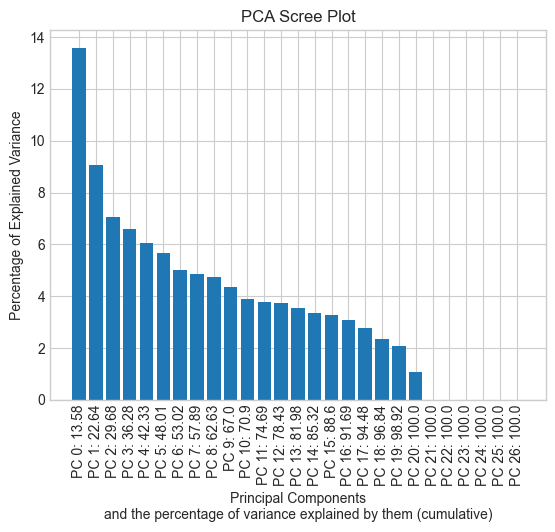

In [8]:
# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_ohe)

# perform PCA
pca = PCA()
pca.fit_transform(scaled_data)

# get variance ratios
scree = list(pca.explained_variance_ratio_ * 100)

# get cumulative variance ratios
cumulative_scree = [sum(scree[: i + 1]) for i in range(len(scree))]

# make labels for scree plot
labels = [
    f"PC {str(i)}: {round(cumulative_scree[i], 2)}"
    for i in range(0, len(cumulative_scree))
]

# Plot principle components
plt.bar(x=range(1, len(scree) + 1), height=scree, tick_label=labels)
plt.ylabel("Percentage of Explained Variance")
plt.xlabel("Principal Components\nand the percentage of variance explained by them (cumulative)")
plt.xticks(rotation=90)
plt.title("PCA Scree Plot")
plt.savefig("plots/scree_plot.png", transparent=True, bbox_inches="tight", dpi=300)
plt.show()


In [9]:
# make a dataframe of the PCA coordinates
pca1 = PCA(n_components=4)
df_pca = pd.DataFrame(
    pca1.fit_transform(scaled_data), columns=["PC1", "PC2", "PC3", "PC4"]
)

In [10]:
# 2D plot (was not really useful)
fig = px.scatter(
    x=df_pca.PC1, y=df_pca.PC3, color=df.G3, color_continuous_scale="tempo"
)
# set x and y labels
fig.update_layout(
    xaxis_title="PC1",
    yaxis_title="PC2",
    title={
        "text": "PCA on SES Proxies",
        "y": 0.95,
        "x": 0.5,
        "xanchor": "center",
        "yanchor": "top",
    },
    coloraxis_colorbar=dict(title="Final Grade"),
)

fig.update_traces(mode="markers")
fig.show()

In [11]:
fig = px.scatter_3d(
    x=df_pca["PC1"],
    y=df_pca["PC2"],
    z=df_pca["PC3"],
    color=df["G3"],
    opacity=0.7,
    color_continuous_scale="tempo",
)

fig.update_layout(
    scene=dict(xaxis_title="PC1", yaxis_title="PC2", zaxis_title="PC3"),
    coloraxis_colorbar=dict(title="Final Grade"),
)
fig.update_traces(mode="markers")
fig.show()

### Analysing factor scores and variable precense in principle components

In [12]:
# Get the factor scores for each feature
factor_scores_PC1 = pca.components_[0]
factor_scores_df = pd.DataFrame(
    {"factor_scores": factor_scores_PC1, "features": df_ohe.columns}
).sort_values(by="factor_scores", ascending=False)

factor_scores_df.set_index("features", inplace=True)
factor_scores_df

,factor_scores
features,
address_R,0.280172
Medu_1,0.265666
Fedu_1,0.264933
Mjob_at_home,0.212313
Fjob_other,0.186489
traveltime_2,0.172726
Mjob_other,0.170600
traveltime_3,0.154010
Medu_2,0.146295


In [13]:
print(factor_scores_df.to_latex(index = True, multirow = True))

\begin{tabular}{lr}
\toprule
 & factor_scores \\
features &  \\
\midrule
address_R & 0.280172 \\
Medu_1 & 0.265666 \\
Fedu_1 & 0.264933 \\
Mjob_at_home & 0.212313 \\
Fjob_other & 0.186489 \\
traveltime_2 & 0.172726 \\
Mjob_other & 0.170600 \\
traveltime_3 & 0.154010 \\
Medu_2 & 0.146295 \\
Fedu_2 & 0.101595 \\
traveltime_4 & 0.093904 \\
Medu_0 & 0.040694 \\
Fedu_0 & 0.037741 \\
Fjob_at_home & 0.029615 \\
Medu_3 & -0.018106 \\
Fjob_services & -0.066476 \\
Mjob_services & -0.101313 \\
Fedu_3 & -0.109005 \\
Fjob_health & -0.133173 \\
Mjob_health & -0.150923 \\
Fjob_teacher & -0.181594 \\
internet & -0.199675 \\
Mjob_teacher & -0.249299 \\
traveltime_1 & -0.273084 \\
address_U & -0.280172 \\
Fedu_4 & -0.290414 \\
Medu_4 & -0.365936 \\
\bottomrule
\end{tabular}



/var/folders/_c/vr22_fg12d7flyy_ll_m264w0000gp/T/ipykernel_54731/2900065816.py:32: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



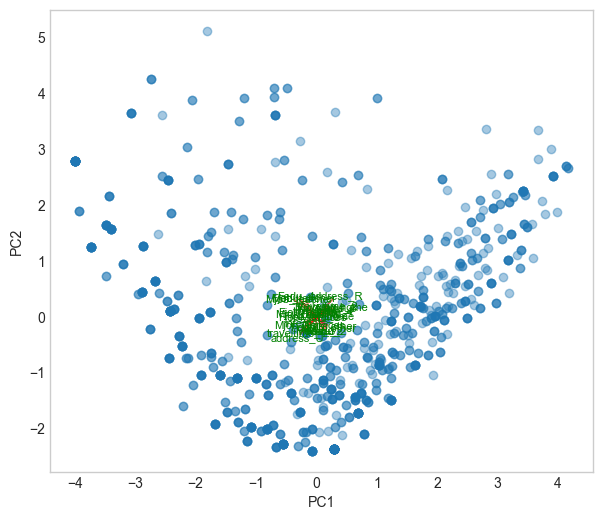

In [14]:
# Make biplot
pca_variable_explained = pd.DataFrame(pca.components_, columns=df_ohe.columns)

fig, ax = plt.subplots(figsize=(7, 6), dpi=100)
ax.scatter(df_pca["PC1"], df_pca["PC2"], alpha=0.4)

for i in pca_variable_explained:
    current_arrow = pca_variable_explained[i][:2]
    ax.arrow(
        0,
        0,
        current_arrow[0],
        current_arrow[1],
        color="r",
        alpha=0.5,
        length_includes_head=True,
        head_width=0.02,
        head_length=0.02,
    )
    ax.text(
        current_arrow[0] * 1.15,
        current_arrow[1] * 1.15,
        i,
        color="g",
        ha="center",
        va="center",
        fontsize=8,
    )
plt.grid()
plt.xlabel("PC1")
plt.ylabel("PC2")
fig.show()

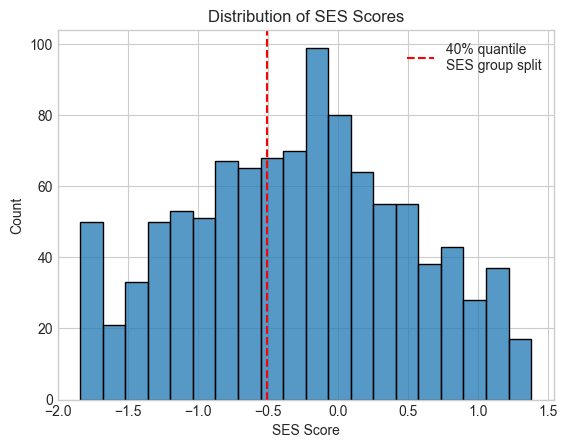

In [15]:
# Aggregate factor scores for each row to calculate SES scores
ses_scores = {}

for idx, row in df_ohe.iterrows():
    current_ses_score = 0
    
    # Calculate the SES score for each row based on the one-hot encoded features
    for i in range(len(row)):
        if row[i] == 1:
            current_feature = df_ohe.columns[i]
            current_ses_score += factor_scores_df.loc[current_feature].values[0] 
    
    ses_scores[idx] = current_ses_score

# Add SES scores to the original DataFrame
df_ohe['SES_score'] = pd.DataFrame.from_dict(ses_scores, orient='index', columns=['SES_score'])['SES_score']

# Plot the distribution of SES scores
sns.histplot(df_ohe['SES_score'], bins=20)
plt.title("Distribution of SES Scores")
plt.xlabel("SES Score")

# Add a vertical line at the 40% quantile
quantile_40 = df_ohe['SES_score'].quantile(0.4)
plt.axvline(x=quantile_40, color='red', linestyle='dashed', label='40% quantile\nSES group split')
plt.legend()

# Save the plot to a file
plt.savefig("plots/ses_score_distribution.png", transparent=True, bbox_inches="tight", dpi=300)

# Show the plot
plt.show()


### Create Socio economic status variable

In [16]:
quantile_60 = df_ohe['SES_score'].quantile(0.6) # 60th percentile
df['SES_score'] = df_ohe['SES_score']
df['SES'] = df_ohe['SES_score'].apply(lambda x: 'middle/rich' if x < quantile_60 else 'lower')
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,course,G_mean,SES_score,SES
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,6,5,6,6,math,5.666667,-0.733077,middle/rich
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,4,5,5,6,math,5.333333,0.176471,lower
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,3,yes,no,yes,no,yes,yes,yes,no,4,3,2,2,3,3,10,7,8,10,math,8.333333,0.176471,lower
3,GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,yes,yes,yes,yes,yes,yes,3,2,2,1,1,5,2,15,14,15,math,14.666667,-1.234671,middle/rich
4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,yes,no,yes,yes,no,no,4,3,2,1,2,5,4,6,10,10,math,8.666667,-0.323278,middle/rich


In [17]:
pd.DataFrame(df['SES'].value_counts())

,count
SES,
middle/rich,625
lower,419


In [18]:
# check that the rich/middle has higher grades than the lower class
pd.DataFrame(df.groupby("SES")["G3"].mean())

,G3
SES,
lower,10.568019
middle/rich,11.860800


### Statistical tests to check if mean final grade across SES groups is statistically significant

In [70]:
alpha = 0.05  # significance level

cols = ["G3", "SES"]
df_math = df[df["course"] == "math"][cols]
df_port = df[df["course"] == "portuguese"][cols]

df_math_upper = df_math[df_math["SES"] == "middle/rich"]["G3"]
df_math_lower = df_math[df_math["SES"] == "lower"]["G3"]

df_port_upper = df_port[df_port["SES"] == "middle/rich"]["G3"]
df_port_lower = df_port[df_port["SES"] == "lower"]["G3"]

# Levens test to test for difference in variance is significant
lev_math_significant = levene(df_math_upper, df_math_lower)[1] < alpha
lev_port_significant = levene(df_port_upper, df_port_lower)[1] < alpha

# If equal_var is True, then a Welsh t-test is performed. Otherwise, a Student t-test is performed to compare the means of two independent samples.
t_math_significant = (
    ttest_ind(df_math_upper, df_math_lower, equal_var=lev_math_significant)[1] < alpha
)
t_port_significant = (
    ttest_ind(df_port_upper, df_port_lower, equal_var=lev_port_significant)[1] < alpha
)

print(
    f"""
Is difference in final grade math significant between SES groups: {t_math_significant} (p: {ttest_ind(
    df_math_upper, df_math_lower, equal_var=lev_math_significant
)[1]})

Is difference in final grade port significant between SES groups: {t_port_significant} (p: {ttest_ind(df_port_upper, df_port_lower, equal_var=lev_port_significant)[1]})
      """
)


Is difference in final grade math significant between SES groups: True (p: 0.0012114700738109492)

Is difference in final grade port significant between SES groups: True (p: 1.3446705080355532e-08)
      
